# **Exploratory Data Analysis**

Import Packages

In [50]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import nasdaqdatalink

# Machine Learning Models
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
import xgboost as xgb
from xgboost import XGBRegressor

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


#--- Starting Here ---#

In [3]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [47]:
NVDA = 'NVDA'
SEMICONDUCTORS = ["TSM", "AVGO", "AMD", "ASML", "MRVL", "ON"]
scaler = MinMaxScaler(feature_range=(0, 1)) # Scaling RSI values for more relatable trends

semiConductor_data = yf.download(NVDA, start='2010-01-01', end='2024-01-01')
semiConductor_data.columns = [col[0] for col in semiConductor_data.columns]
semiConductor_data['Ticker'] = NVDA
semiConductor_data['RSI'] = calculate_rsi(semiConductor_data['Close'], window=14)
semiConductor_data['RSI_Scaled'] = scaler.fit_transform(semiConductor_data['RSI'].values.reshape(-1, 1))
semiConductor_data.reset_index(inplace=True)
semiConductor_data = semiConductor_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
                                                            
#print(f"Total Data Length: {len(semiConductor_data)}")

for stock in SEMICONDUCTORS:
    stock_data = yf.download(stock, start="2010-01-01", end="2024-01-01")
                                                                                                            
    stock_data['Ticker'] = stock
    stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)
    stock_data['RSI_Scaled'] = scaler.fit_transform(stock_data['RSI'].values.reshape(-1, 1))
    stock_data['Close_Scaled'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))
    stock_data['High_Scaled'] = scaler.fit_transform(stock_data['High'].values.reshape(-1, 1))
    stock_data['Low_Scaled'] = scaler.fit_transform(stock_data['Low'].values.reshape(-1, 1))
    stock_data['Open_Scaled'] = scaler.fit_transform(stock_data['Open'].values.reshape(-1, 1))
    stock_data['Volume_Scaled'] = scaler.fit_transform(stock_data['Volume'].values.reshape(-1, 1))
    stock_data.reset_index(inplace=True)
    #stock_data = stock_data[['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled']]
    stock_data.columns = [col[0] for col in stock_data.columns]

    semiConductor_data = pd.concat([semiConductor_data, stock_data], ignore_index=True)

    #print([val[0] for val in semiConductor_data.columns.tolist()])
    #print(f"Total Data Length: {len(semiConductor_data)}")

semiConductor_data = semiConductor_data.dropna()
semiConductor_data.to_csv("semiconductorData.csv", index=False)
print([ i for i in semiConductor_data['Ticker'].unique()])
for stock in SEMICONDUCTORS + [NVDA]:
    print(f"{stock} rows: {len(semiConductor_data.loc[semiConductor_data['Ticker'] == stock])}")

print(semiConductor_data.columns)
semiConductor_data.drop(columns=['Date', 'RSI', 'Close', 'High', 'Low', 'Open', 'Volume'], inplace=True)
print(semiConductor_data.dtypes)
semiConductor_data.head(5)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['TSM', 'AVGO', 'AMD', 'ASML', 'MRVL', 'ON']
TSM rows: 3509
AVGO rows: 3509
AMD rows: 3509
ASML rows: 3509
MRVL rows: 3509
ON rows: 3509
NVDA rows: 0
Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker', 'RSI', 'RSI_Scaled', 'Close_Scaled', 'High_Scaled', 'Low_Scaled', 'Open_Scaled', 'Volume_Scaled'], dtype='object')
Ticker            object
RSI_Scaled       float64
Close_Scaled     float64
High_Scaled      float64
Low_Scaled       float64
Open_Scaled      float64
Volume_Scaled    float64
dtype: object


,Ticker,RSI_Scaled,Close_Scaled,High_Scaled,Low_Scaled,Open_Scaled,Volume_Scaled
3535,TSM,0.173043,0.003295,0.004936,0.003994,0.005091,0.329174
3536,TSM,0.191423,0.003595,0.004162,0.003994,0.002995,0.322241
3537,TSM,0.181906,0.002846,0.003145,0.003286,0.003344,0.344281
3538,TSM,0.184692,0.002796,0.002952,0.003235,0.002695,0.361998
3539,TSM,0.244666,0.003096,0.003242,0.002983,0.003444,0.653475


In [40]:
class lstmDataset(Dataset):
    def __init__(self, data, features, targets, input_window=20, output_window=10):
        self.data = torch.FloatTensor(data.values)
        self.input_window = input_window
        self.output_window = output_window
    
    def __len__(self):
        return len(self.data) - self.input_window - self.output_window + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_window]
        y = self.data[idx + self.input_window : idx + self.input_window + self.output_window, 5]  # Assuming column 7 is the target
        return x, y

In [41]:
features = ["Close", "High", "Low", "Open", "Volume"]
targets = ["RSI_Scaled"]

company_datasets = {}
tickers = semiConductor_data['Ticker'].unique()

# Create an lstmDataset for each company and store it in company_datasets
for ticker in tickers:
    data = semiConductor_data[semiConductor_data['Ticker'] == ticker].drop(columns=["Ticker"])
    company_datasets[ticker] = lstmDataset(data, input_window=20, output_window=10, features=features, targets=targets)
print(company_datasets)

batch_size = 32 
company_loaders = {}

for ticker, dataset in company_datasets.items():
    company_loaders[ticker] = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(company_loaders)

{'ON': <__main__.lstmDataset object at 0x0000027D04079F70>, 'MRVL': <__main__.lstmDataset object at 0x0000027D04078170>, 'ASML': <__main__.lstmDataset object at 0x0000027D04078C20>, 'AMD': <__main__.lstmDataset object at 0x0000027D0407ACC0>, 'AVGO': <__main__.lstmDataset object at 0x0000027D04148AA0>, 'TSM': <__main__.lstmDataset object at 0x0000027D04079A90>}
{'ON': <torch.utils.data.dataloader.DataLoader object at 0x0000027CF09D2030>, 'MRVL': <torch.utils.data.dataloader.DataLoader object at 0x0000027D0407B110>, 'ASML': <torch.utils.data.dataloader.DataLoader object at 0x0000027D0407BB00>, 'AMD': <torch.utils.data.dataloader.DataLoader object at 0x0000027D0407A2A0>, 'AVGO': <torch.utils.data.dataloader.DataLoader object at 0x0000027D0407B710>, 'TSM': <torch.utils.data.dataloader.DataLoader object at 0x0000027D041497C0>}


Define LSTM Model

In [42]:
class LSTMRegressionModel(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.2):
        super(LSTMRegressionModel, self).__init__()
        
        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=input_size, 
                             hidden_size=64, 
                             batch_first=True, 
                             dropout=dropout)
        
        self.lstm2 = nn.LSTM(input_size=64, 
                             hidden_size=128, 
                             batch_first=True, 
                             dropout=dropout)

        self.lstm3 = nn.LSTM(input_size=128, 
                             hidden_size=64, 
                             batch_first=True, 
                             dropout=dropout)
        
        # Fully connected layers
        self.dense1 = nn.Linear(64, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, output_size)
        
        # Activation functions and dropout
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.15)
        
    def forward(self, x):
        # LSTM layers
        out, _ = self.lstm1(x)
        out = self.relu(out)

        out, _ = self.lstm2(out)
        out = self.relu(out)

        out, (hn, _) = self.lstm3(out)  # Use the hidden state from the last LSTM
        out = self.relu(out)
        
        # Fully connected layers
        out = hn[-1]  # Final hidden state from the last LSTM layer
        out = self.dense1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.dense2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.dense3(out)  # Linear output for regression
        
        return out

In [51]:
epochs = 20
model = LSTMRegressionModel(input_size=6, output_size=10) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss() # This is fine for a regression problem from a 0 - 1 range

for ticker, loader in company_loaders.items(): # Key Value type shit
    for epoch in range(epochs):
        for batch_idx, (x_batch, y_batch) in enumerate(loader):
            #print(len(x_batch[0][0]))
            optimizer.zero_grad()

            y_pred = model(x_batch)

            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f"Company: {ticker}, Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")

c:\Users\lordw\OneDrive\Documents\Coding_Projects\AlgoTrAdInG\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Company: ON, Epoch: 0, Batch: 0, Loss: 0.0117194140329957
Company: ON, Epoch: 0, Batch: 100, Loss: 0.0013147764839231968
Company: TSM, Epoch: 0, Batch: 0, Loss: 0.012774263508617878
Company: TSM, Epoch: 0, Batch: 100, Loss: 0.007848275825381279
Company: AVGO, Epoch: 0, Batch: 0, Loss: 0.009212207049131393
Company: AVGO, Epoch: 0, Batch: 100, Loss: 0.0012590615078806877
Company: MRVL, Epoch: 0, Batch: 0, Loss: 0.005185271147638559
Company: MRVL, Epoch: 0, Batch: 100, Loss: 0.0026093071792274714
Company: ASML, Epoch: 0, Batch: 0, Loss: 0.004047248512506485
Company: ASML, Epoch: 0, Batch: 100, Loss: 0.006236533634364605
Company: AMD, Epoch: 0, Batch: 0, Loss: 0.02205934375524521
Company: AMD, Epoch: 0, Batch: 100, Loss: 0.009230786003172398
Company: MRVL, Epoch: 1, Batch: 0, Loss: 0.00483761727809906
Company: MRVL, Epoch: 1, Batch: 100, Loss: 0.002634430769830942
Company: AMD, Epoch: 1, Batch: 0, Loss: 0.008506806567311287
Company: AMD, Epoch: 1, Batch: 100, Loss: 0.008898546919226646
Com

Test Loss after 100 batches: 0.0020804236375261097
Average Test Loss: 0.0021611360903538834
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.2136558  0.2880147  0.2737214  0.21483468 0.10038874 0.18263553
 0.17475103 0.30255592 0.1265029  0.1414725 ]


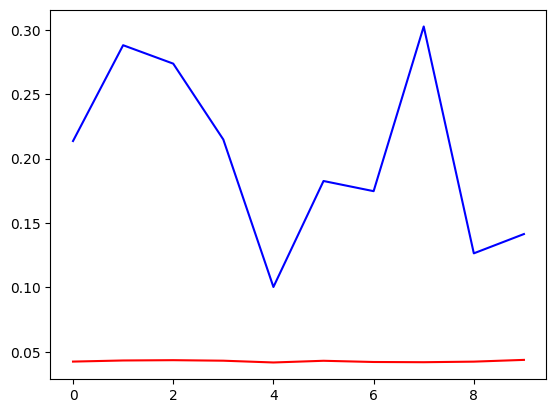

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.2276607  0.19529629 0.15294762 0.20791318 0.21701872 0.12774588
 0.22603996 0.32159343 0.27589703 0.1916382 ]


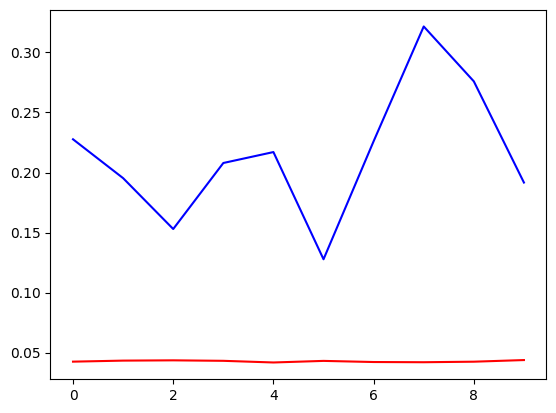

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.1231619  0.09314849 0.06232049 0.04835943 0.20813073 0.24720417
 0.12103519 0.09881859 0.15726513 0.17359912]


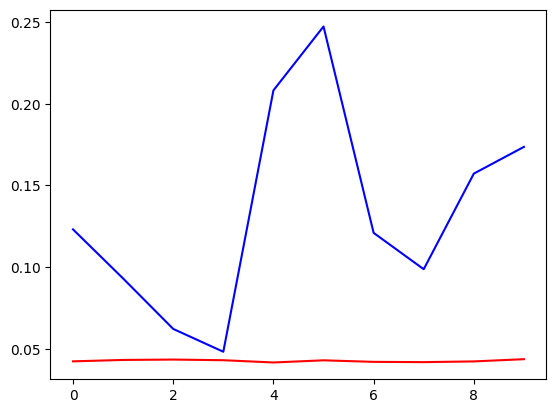

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.10275157 0.08803326 0.24172632 0.13678902 0.11632304 0.16992588
 0.07227605 0.07744356 0.07090996 0.16122003]


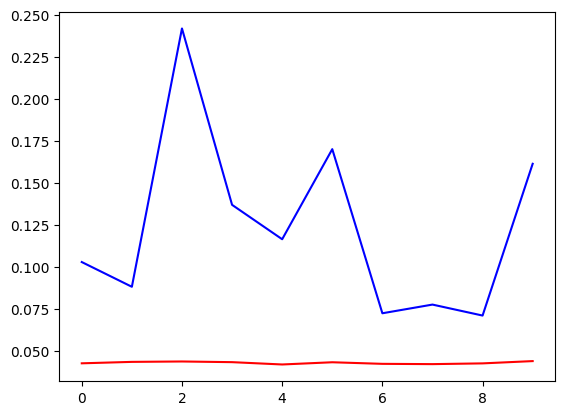

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.25944328 0.4523447  0.24646714 0.23196134 0.1971835  0.2425308
 0.36215773 0.45506    0.40890148 0.21819255]


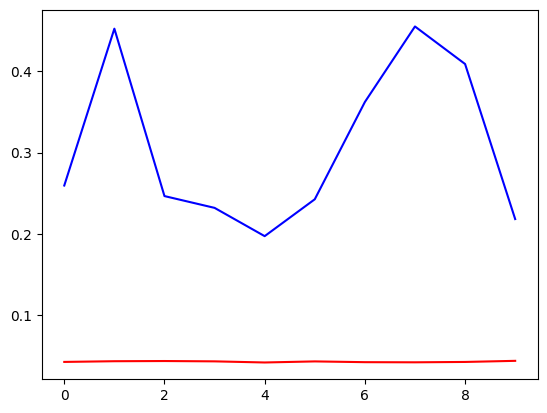

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.19691366 0.15293245 0.2011013  0.17006586 0.14359078 0.11402599
 0.05787143 0.0906558  0.09532073 0.097665  ]


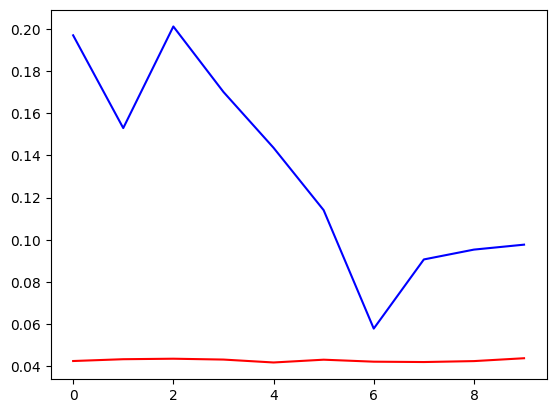

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.11737037 0.09686222 0.08346952 0.14525875 0.09973775 0.0471873
 0.09033705 0.08193815 0.09430039 0.13798645]


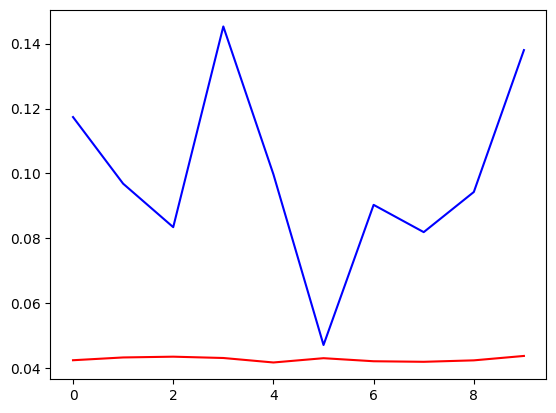

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.16573149 0.05394521 0.08078963 0.08827443 0.16397919 0.08267854
 0.11146753 0.13265872 0.1422483  0.14939074]


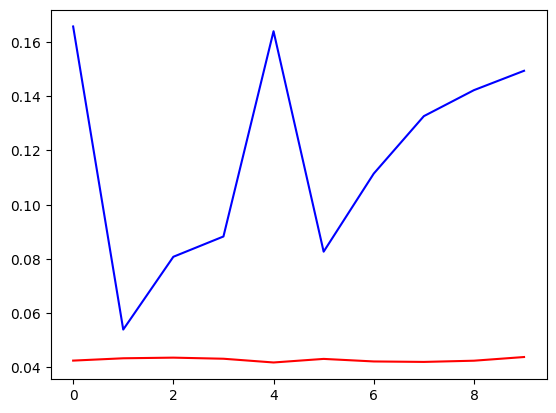

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.07171612 0.05592013 0.10846214 0.06583015 0.09610666 0.11660131
 0.11181158 0.07539275 0.12526669 0.0817324 ]


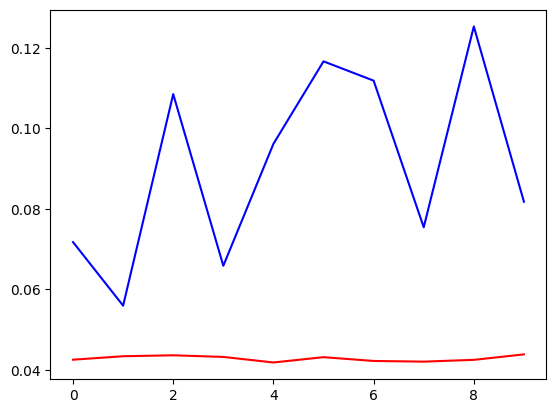

(32, 10)
(32, 10)
Predictions for TSM: [0.04249694 0.04335391 0.04358987 0.04318514 0.04180586 0.04312441
 0.04218479 0.0420149  0.04245889 0.04381841]
True values for TSM: [0.09686222 0.08346952 0.14525875 0.09973775 0.0471873  0.09033705
 0.08193815 0.09430039 0.13798645 0.10103131]


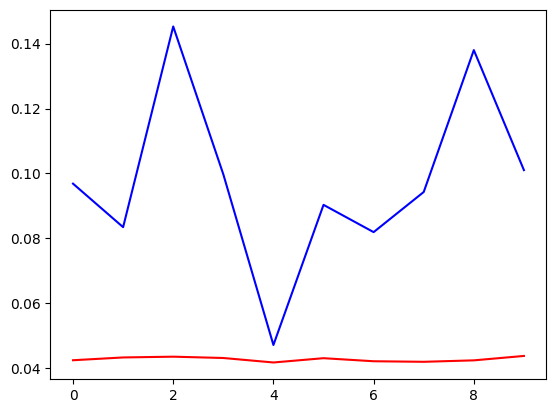

In [52]:
model.eval()
test_loss = 0
num_batches = 0

with torch.no_grad():
    i = 0
    for ticker, loader in company_loaders.items():
        i += 1
        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item()
            num_batches += 1
            
            if num_batches % 100 == 0:
                print(f"Test Loss after {num_batches} batches: {test_loss / num_batches}")
        if i == 1:
            break
        
# Calculate average test loss
avg_test_loss = test_loss / num_batches
print(f"Average Test Loss: {avg_test_loss}")

coordinates = np.linspace(start=0, stop=9, num=10, dtype=int).tolist()
print(coordinates)

ticker = "TSM"  # Example: test for NVIDIA
j = 0
for x_batch, y_batch in company_loaders[ticker]:
    j += 1
    y_pred = model(x_batch)
    
    y_pred = y_pred.detach().numpy()
    y_batch = y_batch.numpy()
    print(y_batch.shape)
    print(y_pred.shape)
    print(f"Predictions for {ticker}: {y_pred[0]}")
    print(f"True values for {ticker}: {y_batch[0]}")
    plt.plot(coordinates, y_batch[0], color="blue")
    plt.plot(coordinates, y_pred[0], color="red")
    plt.show()
    if j == 10:
        break